In [1]:
import numpy as np
import os
from oe_acute import trial_utils as tu
from oe_acute import MNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import tqdm
import glob

import sys
from oe_acute import pyMNE

In [2]:
os.nice(1)

1

### Load dsets

In [3]:
stim_sp = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_64/enc_test_64.npy')
stim_pred = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_64/pred_test_64.npy')
stim_y = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_64/y_test_64.npy')
stim_resp = np.load('/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_64/resp_test_64.npy')

In [4]:
stim_err = stim_y - stim_pred
stim_spec = np.concatenate((stim_sp, stim_err), axis=1)

In [5]:
np.shape(stim_spec), np.shape(stim_resp)

((5706, 96), (5706, 214, 32))

In [6]:
def prepare_MNE_dset(stim_spec, stim_resp, nsegbins=32, concat=True):
    '''
    Create the dataset for fitting MNE model
    '''
    stim_mne = []
    resp_mne = []
    for s, r in zip(stim_spec, stim_resp):
        #nfreq, ntime = s.shape
        #s_segs = np.stack([s[:, n:(n+nsegbins)] for n in range(ntime - nsegbins)], axis=0)
        s_segs = s
        r_segs = np.sum(r, axis=1)
        stim_mne.append(s_segs)
        resp_mne.append(r_segs)
    if concat:
        return np.vstack(stim_mne), np.vstack(resp_mne)
    else:
        return stim_mne, resp_mne

In [7]:
nsegbins = 32

In [8]:
stim_mne = []
resp_mne = []
stim_mne, resp_mne = prepare_MNE_dset(stim_spec, stim_resp, nsegbins=nsegbins)

In [9]:
np.shape(stim_mne), np.shape(resp_mne)

((5706, 96), (5706, 214))

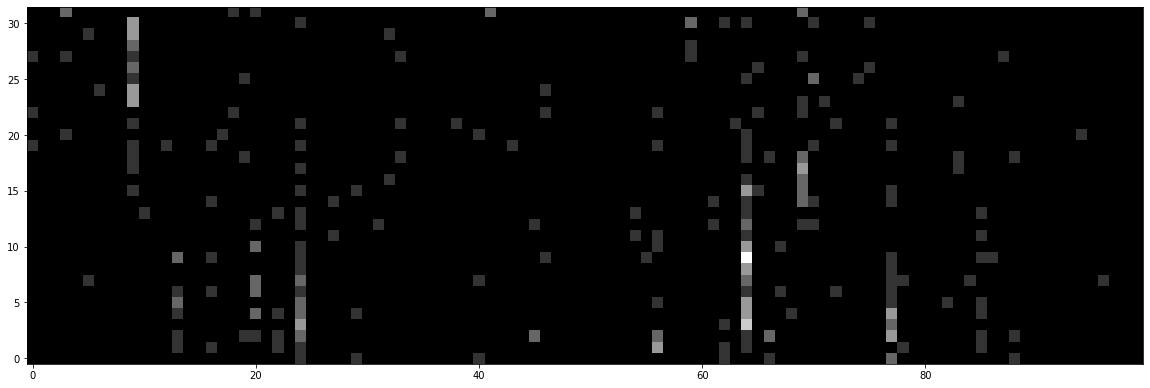

In [10]:
ax = plt.subplots(figsize=(20,8))
plt.imshow(np.transpose(stim_resp[:100, 20, :]), origin='lower', cmap='gray')

### Split into train test sets

In [11]:
len_units = np.shape(resp_mne)[1]

In [12]:
units_to_process = list(np.load('/mnt/cube/srrudrar/temporal_model/units_to_process.npy'))

In [13]:
exp_path = '/mnt/cube/srrudrar/temporal_model/B1240/32x32/stim_resp_32x32_64/error_mne/'

In [14]:
# obtain all preprocessed datas

%matplotlib inline
sdim = 64
n_jackknives = 4

test_output_path = os.path.join(exp_path, 'MNE_test_dset')
os.makedirs(test_output_path, exist_ok=True)
n_eigvec_to_display = 6 # Number of most positive and most negative eigenvectors to display

pfinals = {}
for unit in units_to_process:
    i = units_to_process.index(unit)
    stims_train, resps_train, stims_test, resps_test = MNE.prepare_MNE_train_test_set(stim_mne, resp_mne[:,i][:,np.newaxis], train_pct=0.8, zscore=True, kz_norm_resp=True)
    
    # Save test dataset
    test_dict = {'stims_test':stims_test, 'resps_test':resps_test}
    out_fname = 'unit-{}_MNE.pkl'.format(unit)
    out_f = os.path.join(test_output_path, out_fname)
    with open(out_f, 'wb') as f:
        pickle.dump(test_dict, f)

    # Run MNE
    pfinal = MNE.fit_MNE(stims_train, resps_train, order=2)
    #MNE.plot_MNE(pfinal, unit, figure_output_path)
    pfinals[unit] = pfinal

Iters   tally   ll(test) 
    1       0    0.156403
    2       0    0.154325
    3       0    0.153149
    4       0    0.151427
    5       0    0.152214
    6       1    0.147993
    7       0    0.147930
    8       0    0.155782
    9       1    0.163352
   10       2    0.162458
   11       3    0.157572
   12       4    0.157172
   13       5    0.158228
   14       6    0.159183
   15       7    0.157930
   16       8    0.157828
   17       9    0.157695
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.157439
    2       0    0.155815
    3       0    0.154704
    4       0    0.152354
    5       0    0.152524
    6       1    0.152421
    7       2    0.156253
    8       3    0.157351
    9       4    0.156457
   10       5    0.157886
   11       6    0.157945
   12       7    0.156598
   13       8    0.156606
   14       9    0.156984
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.164908
    2       0    0.174445
    3       

   16       6    0.095478
   17       7    0.095490
   18       8    0.095676
   19       9    0.095596
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.187140
    2       0    0.186907
    3       0    0.187264
    4       1    0.181261
    5       0    0.181180
    6       0    0.182035
    7       1    0.181643
    8       2    0.180544
    9       0    0.180316
   10       0    0.181206
   11       1    0.181458
   12       2    0.182181
   13       3    0.181354
   14       4    0.180777
   15       5    0.180489
   16       6    0.181145
   17       7    0.181180
   18       8    0.181635
   19       9    0.182921
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.198218
    2       0    0.195140
    3       0    0.193107
    4       0    0.196438
    5       1    0.195144
    6       2    0.191700
    7       0    0.191850
    8       1    0.191680
    9       0    0.190891
   10       0    0.190928
   11       1    0.191840
   12       

    1       0    0.123282
    2       0    0.124334
    3       0    0.125048
    4       1    0.122447
    5       0    0.122427
    6       0    0.126832
    7       1    0.126286
    8       2    0.123192
    9       3    0.123242
   10       4    0.122370
   11       0    0.123702
   12       1    0.122815
   13       2    0.122545
   14       3    0.123169
   15       4    0.122394
   16       5    0.122789
   17       6    0.124838
   18       7    0.124910
   19       8    0.123447
   20       9    0.124128
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.128909
    2       0    0.128887
    3       0    0.126223
    4       0    0.125224
    5       0    0.124080
    6       0    0.124382
    7       1    0.124608
    8       2    0.125383
    9       3    0.125627
   10       4    0.125574
   11       5    0.125010
   12       6    0.124842
   13       7    0.124502
   14       8    0.124141
   15       9    0.123734
   16       0    0.124031
   17       

    1       0    0.116036
    2       0    0.112634
    3       0    0.111519
    4       0    0.111745
    5       1    0.110912
    6       0    0.111485
    7       1    0.110584
    8       0    0.110989
    9       1    0.111702
   10       2    0.111160
   11       3    0.111381
   12       4    0.111682
   13       5    0.110766
   14       6    0.110761
   15       7    0.111763
   16       8    0.113161
   17       9    0.114647
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.110068
    2       0    0.109697
    3       0    0.109403
    4       0    0.107984
    5       0    0.107482
    6       0    0.109414
    7       1    0.107733
    8       2    0.106906
    9       0    0.109198
   10       1    0.109774
   11       2    0.107377
   12       3    0.106060
   13       0    0.106455
   14       1    0.107405
   15       2    0.106584
   16       3    0.107248
   17       4    0.106645
   18       5    0.107766
   19       6    0.106871
   20       

    8       0    0.617901
    9       0    0.618331
   10       1    0.618287
   11       2    0.619120
   12       3    0.618637
   13       4    0.619673
   14       5    0.620471
   15       6    0.619935
   16       7    0.620880
   17       8    0.621933
   18       9    0.621200
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.624833
    2       0    0.626719
    3       0    0.624796
    4       0    0.620024
    5       0    0.619568
    6       0    0.620289
    7       1    0.619007
    8       0    0.617638
    9       0    0.618223
   10       1    0.619457
   11       2    0.622531
   12       3    0.620751
   13       4    0.621953
   14       5    0.622847
   15       6    0.623101
   16       7    0.622554
   17       8    0.622675
   18       9    0.623337
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.621606
    2       0    0.617128
    3       0    0.615517
    4       0    0.618695
    5       1    0.619349
    6       

   12       0    0.438092
   13       0    0.438739
   14       1    0.438577
   15       2    0.438303
   16       3    0.441453
   17       4    0.443496
   18       5    0.442618
   19       6    0.443683
   20       7    0.445006
   21       8    0.444915
   22       9    0.445047
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.444862
    2       0    0.443900
    3       0    0.442692
    4       0    0.442048
    5       0    0.441888
    6       0    0.441745
    7       0    0.441882
    8       1    0.441340
    9       0    0.441469
   10       1    0.443852
   11       2    0.444589
   12       3    0.444796
   13       4    0.445702
   14       5    0.447180
   15       6    0.448821
   16       7    0.446988
   17       8    0.446803
   18       9    0.447411
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.238312
    2       0    0.235654
    3       0    0.232936
    4       0    0.231613
    5       0    0.231200
    6       

   23       2    0.111628
   24       3    0.111864
   25       4    0.111567
   26       5    0.111948
   27       6    0.112167
   28       7    0.112529
   29       8    0.112896
   30       9    0.112676
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.108821
    2       0    0.108409
    3       0    0.106749
    4       0    0.106001
    5       0    0.106621
    6       1    0.105547
    7       0    0.105492
    8       0    0.105254
    9       0    0.105530
   10       1    0.106165
   11       2    0.107454
   12       3    0.107630
   13       4    0.107316
   14       5    0.108957
   15       6    0.109299
   16       7    0.109598
   17       8    0.109824
   18       9    0.110899
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.109086
    2       0    0.105689
    3       0    0.102760
    4       0    0.102109
    5       0    0.101889
    6       0    0.101892
    7       1    0.100524
    8       0    0.101541
    9       

    5       0    0.052315
    6       0    0.051955
    7       0    0.051557
    8       0    0.051400
    9       0    0.051686
   10       1    0.051565
   11       2    0.051555
   12       3    0.051621
   13       4    0.051823
   14       5    0.051816
   15       6    0.051864
   16       7    0.051939
   17       8    0.052169
   18       9    0.052735
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.069060
    2       0    0.069271
    3       0    0.067974
    4       0    0.062643
    5       0    0.061365
    6       0    0.060749
    7       0    0.059561
    8       0    0.059150
    9       0    0.059617
   10       1    0.060322
   11       2    0.060810
   12       3    0.061235
   13       4    0.061440
   14       5    0.061073
   15       6    0.062291
   16       7    0.063674
   17       8    0.064656
   18       9    0.066379
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.309690
    2       0    0.306046
    3       

    7       0    0.431169
    8       0    0.434418
    9       1    0.435841
   10       2    0.434019
   11       3    0.433576
   12       4    0.431502
   13       5    0.432059
   14       6    0.431436
   15       7    0.431185
   16       8    0.430257
   17       0    0.430706
   18       1    0.430675
   19       2    0.430044
   20       0    0.429943
   21       0    0.429496
   22       0    0.429346
   23       0    0.429677
   24       1    0.429615
   25       2    0.429902
   26       3    0.431310
   27       4    0.432306
   28       5    0.433053
   29       6    0.435551
   30       7    0.436069
   31       8    0.436453
   32       9    0.436161
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.427481
    2       0    0.424758
    3       0    0.419822
    4       0    0.418314
    5       0    0.418279
    6       0    0.418108
    7       0    0.416141
    8       0    0.415195
    9       0    0.416529
   10       1    0.417277
   11       

    8       2    0.118347
    9       3    0.119536
   10       4    0.120444
   11       5    0.120084
   12       6    0.119884
   13       7    0.120736
   14       8    0.121528
   15       9    0.121697
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.144656
    2       0    0.141658
    3       0    0.130978
    4       0    0.126493
    5       0    0.123374
    6       0    0.124444
    7       1    0.123681
    8       2    0.124940
    9       3    0.126298
   10       4    0.125757
   11       5    0.125514
   12       6    0.126442
   13       7    0.127030
   14       8    0.128593
   15       9    0.131118
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.117281
    2       0    0.117281
    3       0    0.115529
    4       0    0.114403
    5       0    0.115159
    6       1    0.116589
    7       2    0.117359
    8       3    0.118274
    9       4    0.119515
   10       5    0.120734
   11       6    0.121882
   12       

   18       7    0.204463
   19       8    0.204222
   20       9    0.204665
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.203097
    2       0    0.201819
    3       0    0.201012
    4       0    0.200245
    5       0    0.200231
    6       0    0.200249
    7       1    0.200680
    8       2    0.201013
    9       3    0.201453
   10       4    0.200852
   11       5    0.200364
   12       6    0.200340
   13       7    0.200547
   14       8    0.200579
   15       9    0.200414
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.200165
    2       0    0.200589
    3       0    0.200625
    4       1    0.199942
    5       0    0.199269
    6       0    0.197533
    7       0    0.197242
    8       0    0.197355
    9       1    0.196879
   10       0    0.196262
   11       0    0.197013
   12       1    0.197116
   13       2    0.196789
   14       3    0.196734
   15       4    0.197043
   16       5    0.198021
   17       

   18       4    0.607450
   19       5    0.607355
   20       6    0.607016
   21       7    0.606898
   22       8    0.606932
   23       9    0.607628
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.608003
    2       0    0.603860
    3       0    0.602655
    4       0    0.602526
    5       0    0.600433
    6       0    0.599668
    7       0    0.598338
    8       0    0.598006
    9       0    0.598979
   10       1    0.598893
   11       2    0.598038
   12       3    0.597695
   13       0    0.597482
   14       0    0.597545
   15       1    0.598505
   16       2    0.599689
   17       3    0.598500
   18       4    0.597878
   19       5    0.598018
   20       6    0.597767
   21       7    0.597494
   22       8    0.597697
   23       9    0.597856
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.617033
    2       0    0.614923
    3       0    0.614222
    4       0    0.610931
    5       0    0.609706
    6       

   12       6    0.193534
   13       7    0.193508
   14       8    0.191941
   15       0    0.191773
   16       0    0.192403
   17       1    0.192689
   18       2    0.192910
   19       3    0.193670
   20       4    0.193821
   21       5    0.195125
   22       6    0.195917
   23       7    0.195733
   24       8    0.196678
   25       9    0.197270
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.176839
    2       0    0.175893
    3       0    0.174647
    4       0    0.175193
    5       1    0.174421
    6       0    0.173769
    7       0    0.175095
    8       1    0.176987
    9       2    0.177118
   10       3    0.175145
   11       4    0.174948
   12       5    0.174138
   13       6    0.174223
   14       7    0.174605
   15       8    0.174317
   16       9    0.173915
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.189200
    2       0    0.188110
    3       0    0.187993
    4       0    0.188716
    5       

    4       0    0.451170
    5       0    0.449146
    6       0    0.450522
    7       1    0.449400
    8       2    0.449617
    9       3    0.448852
   10       0    0.448654
   11       0    0.448690
   12       1    0.449943
   13       2    0.449364
   14       3    0.449531
   15       4    0.448169
   16       0    0.449808
   17       1    0.450343
   18       2    0.449582
   19       3    0.450039
   20       4    0.449939
   21       5    0.449547
   22       6    0.450245
   23       7    0.450474
   24       8    0.449925
   25       9    0.450035
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.644528
    2       0    0.644903
    3       0    0.642747
    4       0    0.643824
    5       1    0.642878
    6       2    0.643219
    7       3    0.642694
    8       0    0.641185
    9       0    0.639908
   10       0    0.640078
   11       1    0.640634
   12       2    0.640900
   13       3    0.640538
   14       4    0.640874
   15       

Iters   tally   ll(test) 
    1       0    0.410791
    2       0    0.404415
    3       0    0.406257
    4       1    0.402826
    5       0    0.401397
    6       0    0.400605
    7       0    0.400910
    8       1    0.402016
    9       2    0.402120
   10       3    0.401469
   11       4    0.401552
   12       5    0.401961
   13       6    0.403042
   14       7    0.404719
   15       8    0.407133
   16       9    0.409104
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.411207
    2       0    0.406491
    3       0    0.404808
    4       0    0.405195
    5       1    0.406478
    6       2    0.403851
    7       0    0.402785
    8       0    0.402495
    9       0    0.403783
   10       1    0.403567
   11       2    0.402116
   12       0    0.402317
   13       1    0.402575
   14       2    0.402677
   15       3    0.404622
   16       4    0.405391
   17       5    0.406587
   18       6    0.406413
   19       7    0.406683
   20       

    5       1    0.193543
    6       2    0.192272
    7       0    0.191417
    8       0    0.191461
    9       1    0.194004
   10       2    0.194224
   11       3    0.194217
   12       4    0.194150
   13       5    0.194585
   14       6    0.194405
   15       7    0.194415
   16       8    0.194443
   17       9    0.194214
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.475681
    2       0    0.474761
    3       0    0.472426
    4       0    0.472039
    5       0    0.471684
    6       0    0.469437
    7       0    0.469102
    8       0    0.468095
    9       0    0.468383
   10       1    0.468375
   11       2    0.469043
   12       3    0.468916
   13       4    0.468181
   14       5    0.468241
   15       6    0.467965
   16       0    0.467718
   17       0    0.468538
   18       1    0.468770
   19       2    0.467972
   20       3    0.467529
   21       0    0.467602
   22       1    0.467788
   23       2    0.468171
   24       

    7       0    0.354073
    8       0    0.353693
    9       0    0.353501
   10       0    0.355363
   11       1    0.355856
   12       2    0.354905
   13       3    0.353872
   14       4    0.353667
   15       5    0.353689
   16       6    0.354221
   17       7    0.354703
   18       8    0.355164
   19       9    0.354662
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.350649
    2       0    0.348673
    3       0    0.349459
    4       1    0.347023
    5       0    0.343915
    6       0    0.344159
    7       1    0.343096
    8       0    0.343114
    9       1    0.345630
   10       2    0.345713
   11       3    0.343247
   12       4    0.344101
   13       5    0.344473
   14       6    0.344054
   15       7    0.347242
   16       8    0.349454
   17       9    0.346037
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.365434
    2       0    0.361562
    3       0    0.362845
    4       1    0.360492
    5       

    4       1    0.236586
    5       0    0.235179
    6       0    0.236274
    7       1    0.235715
    8       2    0.235430
    9       3    0.236117
   10       4    0.235663
   11       5    0.234969
   12       0    0.235056
   13       1    0.234884
   14       0    0.238601
   15       1    0.239943
   16       2    0.238805
   17       3    0.239815
   18       4    0.241851
   19       5    0.241886
   20       6    0.242055
   21       7    0.240017
   22       8    0.240055
   23       9    0.241134
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.229501
    2       0    0.229435
    3       0    0.226626
    4       0    0.225637
    5       0    0.225319
    6       0    0.225737
    7       1    0.228363
    8       2    0.229937
    9       3    0.231874
   10       4    0.231173
   11       5    0.231542
   12       6    0.230461
   13       7    0.229343
   14       8    0.229345
   15       9    0.228636
minimum of test set found
Iters   tall

   15       6    0.087169
   16       7    0.087161
   17       8    0.087368
   18       9    0.087639
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.083963
    2       0    0.084599
    3       0    0.085474
    4       1    0.083513
    5       0    0.082119
    6       0    0.081762
    7       0    0.082697
    8       1    0.082793
    9       2    0.082368
   10       3    0.082552
   11       4    0.082538
   12       5    0.081940
   13       6    0.082806
   14       7    0.083974
   15       8    0.083309
   16       9    0.083348
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.086567
    2       0    0.084461
    3       0    0.084655
    4       1    0.086088
    5       2    0.085212
    6       3    0.085344
    7       4    0.086214
    8       5    0.085582
    9       6    0.085173
   10       7    0.086886
   11       8    0.086896
   12       9    0.086249
minimum of test set found
Iters   tally   ll(test) 
    1       

    1       0    0.658948
    2       0    0.654457
    3       0    0.652399
    4       0    0.652439
    5       1    0.652568
    6       2    0.652908
    7       3    0.652911
    8       4    0.652608
    9       5    0.651727
   10       0    0.651573
   11       0    0.651438
   12       0    0.651647
   13       1    0.652008
   14       2    0.651540
   15       3    0.651738
   16       4    0.651941
   17       5    0.652302
   18       6    0.653217
   19       7    0.653720
   20       8    0.654412
   21       9    0.655251
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.653938
    2       0    0.649378
    3       0    0.647951
    4       0    0.646883
    5       0    0.644619
    6       0    0.643944
    7       0    0.643662
    8       0    0.643654
    9       0    0.643406
   10       0    0.643571
   11       1    0.643746
   12       2    0.644096
   13       3    0.644432
   14       4    0.645057
   15       5    0.644807
   16       

   15       8    0.205715
   16       9    0.208000
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.215014
    2       0    0.210172
    3       0    0.205538
    4       0    0.206954
    5       1    0.207055
    6       2    0.204382
    7       0    0.203473
    8       0    0.203436
    9       0    0.201770
   10       0    0.201931
   11       1    0.203479
   12       2    0.204366
   13       3    0.205473
   14       4    0.204990
   15       5    0.206634
   16       6    0.207832
   17       7    0.208949
   18       8    0.207960
   19       9    0.206458
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.202418
    2       0    0.198246
    3       0    0.194287
    4       0    0.193984
    5       0    0.194056
    6       1    0.192562
    7       0    0.191597
    8       0    0.192744
    9       1    0.193404
   10       2    0.194678
   11       3    0.193725
   12       4    0.191649
   13       5    0.191281
   14       

   11       0    0.579217
   12       0    0.580068
   13       1    0.580754
   14       2    0.580108
   15       3    0.580653
   16       4    0.581508
   17       5    0.581615
   18       6    0.581782
   19       7    0.581268
   20       8    0.581232
   21       9    0.581348
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.336529
    2       0    0.332513
    3       0    0.324622
    4       0    0.323303
    5       0    0.322374
    6       0    0.321105
    7       0    0.320995
    8       0    0.319795
    9       0    0.320434
   10       1    0.320964
   11       2    0.320834
   12       3    0.320844
   13       4    0.321284
   14       5    0.320681
   15       6    0.320935
   16       7    0.320709
   17       8    0.321341
   18       9    0.322407
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.315611
    2       0    0.313256
    3       0    0.311684
    4       0    0.311345
    5       0    0.310027
    6       

Iters   tally   ll(test) 
    1       0    0.356405
    2       0    0.360106
    3       0    0.353213
    4       0    0.344029
    5       0    0.342214
    6       0    0.338268
    7       0    0.338206
    8       0    0.340348
    9       1    0.339314
   10       2    0.340512
   11       3    0.337444
   12       0    0.338754
   13       1    0.337858
   14       2    0.335133
   15       0    0.334854
   16       0    0.335518
   17       1    0.335411
   18       2    0.335048
   19       3    0.336642
   20       4    0.341359
   21       5    0.341385
   22       6    0.337890
   23       7    0.337940
   24       8    0.337012
   25       9    0.337526
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.228625
    2       0    0.222228
    3       0    0.218930
    4       0    0.220679
    5       1    0.221201
    6       2    0.217402
    7       0    0.219066
    8       1    0.219139
    9       2    0.220743
   10       3    0.223903
   11       

   16       6    0.295568
   17       7    0.296203
   18       8    0.296610
   19       9    0.295800
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.299893
    2       0    0.294416
    3       0    0.295187
    4       1    0.293860
    5       0    0.288958
    6       0    0.289104
    7       1    0.288444
    8       0    0.287575
    9       0    0.287766
   10       1    0.288948
   11       2    0.289353
   12       3    0.290029
   13       4    0.290159
   14       5    0.291421
   15       6    0.292622
   16       7    0.293726
   17       8    0.294444
   18       9    0.295131
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.322307
    2       0    0.317705
    3       0    0.317905
    4       1    0.315765
    5       0    0.311205
    6       0    0.309662
    7       0    0.308994
    8       0    0.309601
    9       1    0.309637
   10       2    0.311301
   11       3    0.310457
   12       4    0.309813
   13       

    5       0    0.299353
    6       0    0.298585
    7       0    0.298321
    8       0    0.297745
    9       0    0.297707
   10       0    0.297510
   11       0    0.297442
   12       0    0.297222
   13       0    0.297247
   14       1    0.297077
   15       0    0.297023
   16       0    0.296944
   17       0    0.296860
   18       0    0.296649
   19       0    0.296688
   20       1    0.296773
   21       2    0.296827
   22       3    0.296950
   23       4    0.297171
   24       5    0.298023
   25       6    0.300488
   26       7    0.301764
   27       8    0.302184
   28       9    0.302236
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.329692
    2       0    0.323573
    3       0    0.319789
    4       0    0.320255
    5       1    0.317017
    6       0    0.314284
    7       0    0.314784
    8       1    0.314050
    9       0    0.314279
   10       1    0.315823
   11       2    0.314748
   12       3    0.313368
   13       

   19       5    0.149797
   20       6    0.149684
   21       7    0.149783
   22       8    0.149773
   23       9    0.149678
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.155848
    2       0    0.154286
    3       0    0.151835
    4       0    0.153708
    5       1    0.152586
    6       2    0.149085
    7       0    0.150037
    8       1    0.148227
    9       0    0.147158
   10       0    0.147060
   11       0    0.147122
   12       1    0.147584
   13       2    0.148504
   14       3    0.147672
   15       4    0.148324
   16       5    0.148355
   17       6    0.148255
   18       7    0.148597
   19       8    0.148384
   20       9    0.147991
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.147575
    2       0    0.147167
    3       0    0.146312
    4       0    0.146156
    5       0    0.146395
    6       1    0.144388
    7       0    0.144037
    8       0    0.144261
    9       1    0.143813
   10       

    1       0    0.187635
    2       0    0.186531
    3       0    0.185908
    4       0    0.185897
    5       0    0.186474
    6       1    0.187419
    7       2    0.186167
    8       3    0.186139
    9       4    0.185894
   10       0    0.185500
   11       0    0.185231
   12       0    0.185207
   13       0    0.185260
   14       1    0.185398
   15       2    0.185365
   16       3    0.186200
   17       4    0.186861
   18       5    0.187370
   19       6    0.187107
   20       7    0.187124
   21       8    0.187097
   22       9    0.186977
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.173821
    2       0    0.172408
    3       0    0.169081
    4       0    0.168323
    5       0    0.166169
    6       0    0.165277
    7       0    0.165016
    8       0    0.165560
    9       1    0.164943
   10       0    0.164996
   11       1    0.164418
   12       0    0.163912
   13       0    0.164001
   14       1    0.163854
   15       

   12       1    0.533729
   13       0    0.533171
   14       0    0.533216
   15       1    0.532408
   16       0    0.532390
   17       0    0.533249
   18       1    0.533105
   19       2    0.532711
   20       3    0.532788
   21       4    0.532598
   22       5    0.532903
   23       6    0.532688
   24       7    0.532948
   25       8    0.532941
   26       9    0.534641
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.115185
    2       0    0.109347
    3       0    0.107548
    4       0    0.106074
    5       0    0.105525
    6       0    0.105549
    7       1    0.104875
    8       0    0.104517
    9       0    0.104233
   10       0    0.103940
   11       0    0.103652
   12       0    0.103106
   13       0    0.102471
   14       0    0.102384
   15       0    0.102604
   16       1    0.102725
   17       2    0.102117
   18       0    0.101664
   19       0    0.101454
   20       0    0.101750
   21       1    0.102772
   22       

   17       9    0.635451
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.638766
    2       0    0.634620
    3       0    0.632369
    4       0    0.631608
    5       0    0.630305
    6       0    0.629845
    7       0    0.629055
    8       0    0.628842
    9       0    0.629092
   10       1    0.630599
   11       2    0.630278
   12       3    0.630810
   13       4    0.631022
   14       5    0.631506
   15       6    0.631662
   16       7    0.631140
   17       8    0.631164
   18       9    0.631594
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.640321
    2       0    0.635522
    3       0    0.633291
    4       0    0.634298
    5       1    0.632409
    6       0    0.632114
    7       0    0.631307
    8       0    0.630045
    9       0    0.630068
   10       1    0.630544
   11       2    0.630894
   12       3    0.630566
   13       4    0.630513
   14       5    0.631026
   15       6    0.631649
   16       

   16       4    0.208323
   17       5    0.206445
   18       6    0.206253
   19       7    0.206368
   20       8    0.206303
   21       9    0.206068
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.207142
    2       0    0.205392
    3       0    0.203999
    4       0    0.203502
    5       0    0.203341
    6       0    0.202923
    7       0    0.202562
    8       0    0.202452
    9       0    0.202236
   10       0    0.202621
   11       1    0.204181
   12       2    0.206640
   13       3    0.208333
   14       4    0.209062
   15       5    0.208258
   16       6    0.207747
   17       7    0.207429
   18       8    0.206967
   19       9    0.206745
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.439625
    2       0    0.436894
    3       0    0.436376
    4       0    0.435971
    5       0    0.434933
    6       0    0.433907
    7       0    0.433709
    8       0    0.433834
    9       1    0.432847
   10       

   10       0    0.097645
   11       1    0.098007
   12       2    0.096480
   13       0    0.096726
   14       1    0.098625
   15       2    0.099304
   16       3    0.099759
   17       4    0.098133
   18       5    0.097867
   19       6    0.098609
   20       7    0.099001
   21       8    0.099222
   22       9    0.099330
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.103918
    2       0    0.102927
    3       0    0.100454
    4       0    0.101650
    5       1    0.101534
    6       2    0.100044
    7       0    0.099270
    8       0    0.100529
    9       1    0.099404
   10       2    0.099929
   11       3    0.100793
   12       4    0.102576
   13       5    0.104001
   14       6    0.104492
   15       7    0.105551
   16       8    0.105151
   17       9    0.104182
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.101356
    2       0    0.097940
    3       0    0.094893
    4       0    0.096167
    5       

    5       0    0.216272
    6       1    0.214698
    7       0    0.213044
    8       0    0.212308
    9       0    0.215228
   10       1    0.217650
   11       2    0.215768
   12       3    0.215175
   13       4    0.216062
   14       5    0.216237
   15       6    0.214819
   16       7    0.214532
   17       8    0.214563
   18       9    0.215224
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.208119
    2       0    0.206287
    3       0    0.207099
    4       1    0.204357
    5       0    0.204060
    6       0    0.202013
    7       0    0.202173
    8       1    0.203317
    9       2    0.203699
   10       3    0.202006
   11       0    0.200628
   12       0    0.200561
   13       0    0.200693
   14       1    0.200484
   15       0    0.200237
   16       0    0.200414
   17       1    0.200436
   18       2    0.200849
   19       3    0.200553
   20       4    0.200347
   21       5    0.200676
   22       6    0.200913
   23       

   21       7    0.500211
   22       8    0.500004
   23       9    0.501185
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.527660
    2       0    0.526757
    3       0    0.515553
    4       0    0.514976
    5       0    0.512712
    6       0    0.510453
    7       0    0.509183
    8       0    0.508053
    9       0    0.507248
   10       0    0.509817
   11       1    0.512086
   12       2    0.509322
   13       3    0.508816
   14       4    0.508209
   15       5    0.507381
   16       6    0.506767
   17       0    0.506923
   18       1    0.506469
   19       0    0.505641
   20       0    0.505558
   21       0    0.505551
   22       0    0.505231
   23       0    0.505525
   24       1    0.506089
   25       2    0.506595
   26       3    0.506150
   27       4    0.506188
   28       5    0.506221
   29       6    0.506494
   30       7    0.508724
   31       8    0.511885
   32       9    0.512942
minimum of test set found
Iters   tall

   20       6    0.141551
   21       7    0.141513
   22       8    0.142275
   23       9    0.144316
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.141202
    2       0    0.138650
    3       0    0.138478
    4       0    0.138450
    5       0    0.137712
    6       0    0.137223
    7       0    0.136428
    8       0    0.136447
    9       1    0.136243
   10       0    0.137727
   11       1    0.137922
   12       2    0.137518
   13       3    0.137893
   14       4    0.137304
   15       5    0.137511
   16       6    0.137642
   17       7    0.138621
   18       8    0.138412
   19       9    0.139598
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.154355
    2       0    0.151129
    3       0    0.148399
    4       0    0.148996
    5       1    0.147906
    6       0    0.146237
    7       0    0.146726
    8       1    0.147607
    9       2    0.147290
   10       3    0.146607
   11       4    0.146850
   12       

    1       0    0.648962
    2       0    0.645062
    3       0    0.644466
    4       0    0.644474
    5       1    0.645631
    6       2    0.644114
    7       0    0.643028
    8       0    0.642911
    9       0    0.641187
   10       0    0.641068
   11       0    0.641235
   12       1    0.640404
   13       0    0.640581
   14       1    0.640066
   15       0    0.641356
   16       1    0.642331
   17       2    0.641815
   18       3    0.641576
   19       4    0.642261
   20       5    0.643095
   21       6    0.642885
   22       7    0.641868
   23       8    0.642157
   24       9    0.642689
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.095335
    2       0    0.092007
    3       0    0.088305
    4       0    0.088528
    5       1    0.086898
    6       0    0.085901
    7       0    0.087141
    8       1    0.087202
    9       2    0.086229
   10       3    0.086036
   11       4    0.085499
   12       0    0.086313
   13       

    1       0    0.248602
    2       0    0.249861
    3       0    0.248830
    4       0    0.247019
    5       0    0.247489
    6       1    0.249762
    7       2    0.250426
    8       3    0.248441
    9       4    0.247604
   10       5    0.248095
   11       6    0.247266
   12       7    0.246977
   13       0    0.245474
   14       0    0.245290
   15       0    0.245316
   16       1    0.245728
   17       2    0.246595
   18       3    0.248765
   19       4    0.249817
   20       5    0.251576
   21       6    0.252031
   22       7    0.251779
   23       8    0.251715
   24       9    0.251728
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.221869
    2       0    0.221698
    3       0    0.220200
    4       0    0.219745
    5       0    0.217360
    6       0    0.218056
    7       1    0.217828
    8       2    0.216381
    9       0    0.216837
   10       1    0.219066
   11       2    0.217102
   12       3    0.216289
   13       

    6       1    0.213851
    7       0    0.214729
    8       1    0.218195
    9       2    0.217685
   10       3    0.215849
   11       4    0.216189
   12       5    0.215619
   13       6    0.215712
   14       7    0.217357
   15       8    0.217105
   16       9    0.218006
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.148626
    2       0    0.147478
    3       0    0.145187
    4       0    0.144074
    5       0    0.142734
    6       0    0.143332
    7       1    0.143111
    8       2    0.142803
    9       3    0.142594
   10       0    0.140828
   11       0    0.140566
   12       0    0.140870
   13       1    0.140839
   14       2    0.141413
   15       3    0.142710
   16       4    0.142794
   17       5    0.141775
   18       6    0.141573
   19       7    0.141912
   20       8    0.142810
   21       9    0.142400
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.150077
    2       0    0.148608
    3       

    3       0    0.222631
    4       0    0.222339
    5       0    0.222588
    6       1    0.222408
    7       2    0.222201
    8       0    0.221963
    9       0    0.221306
   10       0    0.221374
   11       1    0.224840
   12       2    0.227587
   13       3    0.227681
   14       4    0.226925
   15       5    0.227323
   16       6    0.227306
   17       7    0.226955
   18       8    0.226925
   19       9    0.226634
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.224548
    2       0    0.224962
    3       0    0.224630
    4       0    0.224163
    5       0    0.222971
    6       0    0.223279
    7       1    0.223856
    8       2    0.222967
    9       0    0.222402
   10       0    0.222368
   11       0    0.224095
   12       1    0.223707
   13       2    0.224444
   14       3    0.224627
   15       4    0.223998
   16       5    0.223172
   17       6    0.223087
   18       7    0.223216
   19       8    0.223171
   20       

   12       5    0.262895
   13       6    0.262715
   14       7    0.262955
   15       8    0.263074
   16       9    0.264337
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.267453
    2       0    0.267807
    3       0    0.268983
    4       1    0.267724
    5       0    0.267593
    6       0    0.267384
    7       0    0.267918
    8       1    0.267902
    9       2    0.267697
   10       3    0.267635
   11       4    0.267592
   12       5    0.267905
   13       6    0.268112
   14       7    0.267973
   15       8    0.268141
   16       9    0.268228
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.268519
    2       0    0.268750
    3       0    0.268782
    4       1    0.267768
    5       0    0.267213
    6       0    0.266566
    7       0    0.266122
    8       0    0.266257
    9       1    0.266623
   10       2    0.265867
   11       0    0.265315
   12       0    0.266290
   13       1    0.268537
   14       

   18       7    0.407198
   19       8    0.407212
   20       9    0.407382
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.404357
    2       0    0.401450
    3       0    0.401231
    4       0    0.400347
    5       0    0.400323
    6       0    0.400201
    7       0    0.400155
    8       0    0.399004
    9       0    0.398744
   10       0    0.398631
   11       0    0.399526
   12       1    0.399988
   13       2    0.400394
   14       3    0.399971
   15       4    0.399842
   16       5    0.399811
   17       6    0.399829
   18       7    0.400282
   19       8    0.400329
   20       9    0.400493
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.402459
    2       0    0.401914
    3       0    0.404535
    4       1    0.403231
    5       2    0.403529
    6       3    0.401539
    7       0    0.402507
    8       1    0.401820
    9       2    0.400579
   10       0    0.400626
   11       1    0.400114
   12       

    4       1    0.226664
    5       2    0.224733
    6       3    0.224668
    7       4    0.224028
    8       0    0.224003
    9       0    0.222550
   10       0    0.222829
   11       1    0.222599
   12       2    0.222397
   13       0    0.223367
   14       1    0.224914
   15       2    0.224540
   16       3    0.224907
   17       4    0.224497
   18       5    0.224603
   19       6    0.226000
   20       7    0.226877
   21       8    0.226753
   22       9    0.228574
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.225388
    2       0    0.223770
    3       0    0.222518
    4       0    0.223576
    5       1    0.221788
    6       0    0.220857
    7       0    0.220697
    8       0    0.219604
    9       0    0.219147
   10       0    0.219341
   11       1    0.217985
   12       0    0.217606
   13       0    0.217363
   14       0    0.216644
   15       0    0.216933
   16       1    0.218084
   17       2    0.218690
   18       

   18       6    0.317354
   19       7    0.316766
   20       8    0.317823
   21       9    0.318299
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.292015
    2       0    0.289458
    3       0    0.290233
    4       1    0.288077
    5       0    0.287175
    6       0    0.286727
    7       0    0.287667
    8       1    0.287162
    9       2    0.286806
   10       3    0.286041
   11       0    0.285903
   12       0    0.285462
   13       0    0.285727
   14       1    0.286540
   15       2    0.287593
   16       3    0.288214
   17       4    0.288613
   18       5    0.290680
   19       6    0.290769
   20       7    0.290986
   21       8    0.290982
   22       9    0.291125
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.294675
    2       0    0.293315
    3       0    0.293763
    4       1    0.297272
    5       2    0.294666
    6       3    0.293061
    7       0    0.292536
    8       0    0.292355
    9       

   19       0    0.286074
   20       0    0.286347
   21       1    0.286563
   22       2    0.287209
   23       3    0.287595
   24       4    0.287777
   25       5    0.287705
   26       6    0.288295
   27       7    0.289800
   28       8    0.292597
   29       9    0.297313
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.170769
    2       0    0.167633
    3       0    0.163920
    4       0    0.164792
    5       1    0.162312
    6       0    0.163363
    7       1    0.161895
    8       0    0.160759
    9       0    0.161345
   10       1    0.160317
   11       0    0.160684
   12       1    0.160757
   13       2    0.160426
   14       3    0.160204
   15       0    0.161212
   16       1    0.161000
   17       2    0.160253
   18       3    0.161079
   19       4    0.161034
   20       5    0.160108
   21       0    0.160228
   22       1    0.160613
   23       2    0.160340
   24       3    0.160295
   25       4    0.160614
   26       

   12       6    0.175978
   13       7    0.176229
   14       8    0.176509
   15       9    0.177883
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.183950
    2       0    0.183405
    3       0    0.180929
    4       0    0.181134
    5       1    0.180903
    6       0    0.180089
    7       0    0.180051
    8       0    0.179830
    9       0    0.179833
   10       1    0.180229
   11       2    0.180550
   12       3    0.180447
   13       4    0.180995
   14       5    0.181238
   15       6    0.181100
   16       7    0.181114
   17       8    0.181180
   18       9    0.181456
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.181283
    2       0    0.178134
    3       0    0.177629
    4       0    0.177294
    5       0    0.177757
    6       1    0.178304
    7       2    0.178086
    8       3    0.177871
    9       4    0.177897
   10       5    0.177587
   11       6    0.177307
   12       7    0.177447
   13       

    5       1    0.197547
    6       2    0.192079
    7       0    0.190474
    8       0    0.189482
    9       0    0.189107
   10       0    0.187728
   11       0    0.187607
   12       0    0.186764
   13       0    0.187076
   14       1    0.187756
   15       2    0.186814
   16       3    0.187870
   17       4    0.187238
   18       5    0.187038
   19       6    0.187586
   20       7    0.187544
   21       8    0.186751
   22       0    0.187145
   23       1    0.187314
   24       2    0.188814
   25       3    0.188830
   26       4    0.187875
   27       5    0.188172
   28       6    0.188034
   29       7    0.187857
   30       8    0.188742
   31       9    0.189893
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.222485
    2       0    0.217607
    3       0    0.217728
    4       1    0.212891
    5       0    0.211631
    6       0    0.209872
    7       0    0.208646
    8       0    0.209091
    9       1    0.206754
   10       

    7       2    0.447589
    8       3    0.443921
    9       0    0.441866
   10       0    0.442384
   11       1    0.440912
   12       0    0.440688
   13       0    0.441863
   14       1    0.440959
   15       2    0.440633
   16       0    0.440574
   17       0    0.441714
   18       1    0.442226
   19       2    0.442402
   20       3    0.445826
   21       4    0.450551
   22       5    0.448945
   23       6    0.449232
   24       7    0.448293
   25       8    0.449108
   26       9    0.449016
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.470956
    2       0    0.467822
    3       0    0.465485
    4       0    0.463132
    5       0    0.462240
    6       0    0.460564
    7       0    0.458723
    8       0    0.457442
    9       0    0.455259
   10       0    0.452575
   11       0    0.452548
   12       0    0.453905
   13       1    0.454827
   14       2    0.455749
   15       3    0.453161
   16       4    0.453000
   17       

Iters   tally   ll(test) 
    1       0    0.212017
    2       0    0.206424
    3       0    0.208541
    4       1    0.206033
    5       0    0.208773
    6       1    0.208475
    7       2    0.209843
    8       3    0.212754
    9       4    0.217799
   10       5    0.218337
   11       6    0.216294
   12       7    0.216162
   13       8    0.216551
   14       9    0.215701
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.210855
    2       0    0.210935
    3       0    0.210773
    4       0    0.208641
    5       0    0.208854
    6       1    0.209122
    7       2    0.207875
    8       0    0.207818
    9       0    0.207337
   10       0    0.207038
   11       0    0.207335
   12       1    0.207623
   13       2    0.207366
   14       3    0.206811
   15       0    0.207330
   16       1    0.207333
   17       2    0.207268
   18       3    0.207912
   19       4    0.209013
   20       5    0.209796
   21       6    0.209721
   22       

    2       0    0.287532
    3       0    0.286174
    4       0    0.286179
    5       1    0.287261
    6       2    0.286116
    7       0    0.283946
    8       0    0.283611
    9       0    0.283539
   10       0    0.284214
   11       1    0.283341
   12       0    0.282784
   13       0    0.283036
   14       1    0.283299
   15       2    0.283086
   16       3    0.283512
   17       4    0.283867
   18       5    0.284652
   19       6    0.284925
   20       7    0.287697
   21       8    0.288920
   22       9    0.290164
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.282204
    2       0    0.281499
    3       0    0.276373
    4       0    0.274641
    5       0    0.274472
    6       0    0.274067
    7       0    0.274092
    8       1    0.274686
    9       2    0.275390
   10       3    0.274701
   11       4    0.273851
   12       0    0.273885
   13       1    0.274053
   14       2    0.274826
   15       3    0.276647
   16       

   12       0    0.522197
   13       0    0.521664
   14       0    0.521533
   15       0    0.524495
   16       1    0.526386
   17       2    0.524853
   18       3    0.524127
   19       4    0.524542
   20       5    0.524483
   21       6    0.524364
   22       7    0.523958
   23       8    0.523752
   24       9    0.524039
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.096268
    2       0    0.096380
    3       0    0.097772
    4       1    0.096390
    5       2    0.095199
    6       0    0.094250
    7       0    0.093849
    8       0    0.094115
    9       1    0.093811
   10       0    0.094477
   11       1    0.095588
   12       2    0.095446
   13       3    0.095317
   14       4    0.094629
   15       5    0.094573
   16       6    0.094555
   17       7    0.094492
   18       8    0.094686
   19       9    0.094828
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.096907
    2       0    0.095961
    3       

    8       2    0.099514
    9       3    0.099197
   10       4    0.102049
   11       5    0.100228
   12       6    0.102597
   13       7    0.100409
   14       8    0.100053
   15       9    0.097568
   16       0    0.098133
   17       1    0.100115
   18       2    0.102254
   19       3    0.100263
   20       4    0.098860
   21       5    0.099402
   22       6    0.099787
   23       7    0.099415
   24       8    0.101231
   25       9    0.101560
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.114674
    2       0    0.113271
    3       0    0.111812
    4       0    0.112485
    5       1    0.111776
    6       0    0.112539
    7       1    0.110937
    8       0    0.109835
    9       0    0.110523
   10       1    0.110338
   11       2    0.111097
   12       3    0.110879
   13       4    0.111367
   14       5    0.112413
   15       6    0.111187
   16       7    0.113146
   17       8    0.113067
   18       9    0.117463
minimum of t

    3       0    0.183705
    4       0    0.183364
    5       0    0.185477
    6       1    0.188335
    7       2    0.190275
    8       3    0.194392
    9       4    0.202203
   10       5    0.208391
   11       6    0.205540
   12       7    0.207422
   13       8    0.208142
   14       9    0.207162
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.170820
    2       0    0.171395
    3       0    0.172836
    4       1    0.172869
    5       2    0.175132
    6       3    0.180709
    7       4    0.182339
    8       5    0.186185
    9       6    0.192241
   10       7    0.193905
   11       8    0.193823
   12       9    0.194650
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.175076
    2       0    0.174369
    3       0    0.180381
    4       1    0.184437
    5       2    0.184547
    6       3    0.184466
    7       4    0.182505
    8       5    0.181668
    9       6    0.183628
   10       7    0.188744
   11       

   12       2    0.218705
   13       0    0.218525
   14       0    0.218986
   15       1    0.220659
   16       2    0.223967
   17       3    0.229604
   18       4    0.234577
   19       5    0.233723
   20       6    0.232602
   21       7    0.235623
   22       8    0.238590
   23       9    0.238429
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.223685
    2       0    0.223800
    3       0    0.217748
    4       0    0.217382
    5       0    0.217328
    6       0    0.221767
    7       1    0.225819
    8       2    0.223302
    9       3    0.225229
   10       4    0.224739
   11       5    0.223680
   12       6    0.221743
   13       7    0.222541
   14       8    0.223146
   15       9    0.219536
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.199916
    2       0    0.195079
    3       0    0.197021
    4       1    0.198389
    5       2    0.202993
    6       3    0.201389
    7       4    0.203292
    8       

   15       6    0.550855
   16       7    0.552222
   17       8    0.553469
   18       9    0.553467
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.310979
    2       0    0.305335
    3       0    0.300990
    4       0    0.298617
    5       0    0.297331
    6       0    0.296506
    7       0    0.296035
    8       0    0.296009
    9       0    0.295019
   10       0    0.298697
   11       1    0.299584
   12       2    0.296513
   13       3    0.296138
   14       4    0.295891
   15       5    0.295215
   16       6    0.295358
   17       7    0.295225
   18       8    0.295918
   19       9    0.296903
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.295106
    2       0    0.294253
    3       0    0.291161
    4       0    0.290379
    5       0    0.288936
    6       0    0.288120
    7       0    0.287658
    8       0    0.286828
    9       0    0.288245
   10       1    0.289354
   11       2    0.288147
   12       

    9       1    0.040915
   10       2    0.040927
   11       3    0.040590
   12       0    0.040597
   13       1    0.040941
   14       2    0.040715
   15       3    0.040454
   16       0    0.040437
   17       0    0.040284
   18       0    0.040294
   19       1    0.040382
   20       2    0.040347
   21       3    0.040323
   22       4    0.040383
   23       5    0.040676
   24       6    0.041282
   25       7    0.041801
   26       8    0.042208
   27       9    0.042201
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.024139
    2       0    0.023909
    3       0    0.023378
    4       0    0.023905
    5       1    0.023494
    6       2    0.022302
    7       0    0.022297
    8       0    0.022178
    9       0    0.022177
   10       0    0.022115
   11       0    0.021987
   12       0    0.022324
   13       1    0.023059
   14       2    0.023986
   15       3    0.023953
   16       4    0.023604
   17       5    0.023501
   18       

   11       2    0.136727
   12       3    0.137826
   13       4    0.138677
   14       5    0.139846
   15       6    0.139300
   16       7    0.139446
   17       8    0.139425
   18       9    0.139498
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.142257
    2       0    0.137796
    3       0    0.136649
    4       0    0.137575
    5       1    0.135472
    6       0    0.135647
    7       1    0.137285
    8       2    0.138773
    9       3    0.140876
   10       4    0.141876
   11       5    0.140833
   12       6    0.139878
   13       7    0.139802
   14       8    0.139549
   15       9    0.139185
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.132040
    2       0    0.131229
    3       0    0.132222
    4       1    0.132917
    5       2    0.132200
    6       3    0.130334
    7       0    0.131099
    8       1    0.130498
    9       2    0.129174
   10       0    0.129167
   11       0    0.128687
   12       

   11       3    0.194501
   12       4    0.192720
   13       5    0.192415
   14       6    0.193425
   15       7    0.192750
   16       8    0.193210
   17       9    0.193616
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.171221
    2       0    0.161981
    3       0    0.163994
    4       1    0.159514
    5       0    0.160402
    6       1    0.160763
    7       2    0.160390
    8       3    0.157710
    9       0    0.157393
   10       0    0.158825
   11       1    0.158133
   12       2    0.157436
   13       3    0.156728
   14       0    0.158605
   15       1    0.158601
   16       2    0.157764
   17       3    0.158643
   18       4    0.158281
   19       5    0.159159
   20       6    0.159092
   21       7    0.158743
   22       8    0.160260
   23       9    0.160665
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.229821
    2       0    0.228062
    3       0    0.228101
    4       1    0.227974
    5       

    1       0    0.144446
    2       0    0.144172
    3       0    0.142559
    4       0    0.140340
    5       0    0.139843
    6       0    0.140513
    7       1    0.140214
    8       2    0.139331
    9       0    0.138735
   10       0    0.140298
   11       1    0.141901
   12       2    0.141045
   13       3    0.141636
   14       4    0.141776
   15       5    0.141168
   16       6    0.141430
   17       7    0.140997
   18       8    0.140819
   19       9    0.141483
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.139826
    2       0    0.140092
    3       0    0.139640
    4       0    0.137531
    5       0    0.136592
    6       0    0.135635
    7       0    0.137640
    8       1    0.138905
    9       2    0.136044
   10       3    0.136349
   11       4    0.136019
   12       5    0.135532
   13       0    0.136345
   14       1    0.136449
   15       2    0.136288
   16       3    0.135832
   17       4    0.136855
   18       

   12       7    0.186070
   13       8    0.186254
   14       9    0.186582
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.195297
    2       0    0.193459
    3       0    0.191184
    4       0    0.193441
    5       1    0.194591
    6       2    0.191651
    7       3    0.192772
    8       4    0.193099
    9       5    0.192214
   10       6    0.194488
   11       7    0.200406
   12       8    0.201763
   13       9    0.200314
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.183718
    2       0    0.184213
    3       0    0.188555
    4       1    0.189030
    5       2    0.192608
    6       3    0.195541
    7       4    0.196470
    8       5    0.199790
    9       6    0.200295
   10       7    0.199959
   11       8    0.199234
   12       9    0.199400
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.184748
    2       0    0.184734
    3       0    0.185875
    4       1    0.187736
    5       

   11       0    0.155959
   12       0    0.156493
   13       1    0.156560
   14       2    0.156322
   15       3    0.155960
   16       4    0.155979
   17       5    0.155854
   18       0    0.156167
   19       1    0.157579
   20       2    0.157599
   21       3    0.157558
   22       4    0.156884
   23       5    0.156839
   24       6    0.157182
   25       7    0.157505
   26       8    0.157506
   27       9    0.157718
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.162250
    2       0    0.162013
    3       0    0.163056
    4       1    0.162578
    5       2    0.162092
    6       3    0.161306
    7       0    0.160698
    8       0    0.160880
    9       1    0.161502
   10       2    0.161920
   11       3    0.162133
   12       4    0.163952
   13       5    0.164887
   14       6    0.164136
   15       7    0.162873
   16       8    0.162620
   17       9    0.162782
minimum of test set found
Iters   tally   ll(test) 
    1       

    4       0    0.065731
    5       0    0.064465
    6       0    0.063599
    7       0    0.062184
    8       0    0.062041
    9       0    0.062347
   10       1    0.061707
   11       0    0.061717
   12       1    0.062664
   13       2    0.063204
   14       3    0.062609
   15       4    0.062159
   16       5    0.062100
   17       6    0.061909
   18       7    0.061904
   19       8    0.061862
   20       9    0.062023
minimum of test set found
Iters   tally   ll(test) 
    1       0    0.079382
    2       0    0.070809
    3       0    0.067005
    4       0    0.066032
    5       0    0.065243
    6       0    0.064792
    7       0    0.064706
    8       0    0.064732
    9       1    0.064906
   10       2    0.064747
   11       3    0.064446
   12       0    0.064178
   13       0    0.063535
   14       0    0.063300
   15       0    0.063053
   16       0    0.063092
   17       1    0.063225
   18       2    0.062961
   19       0    0.062738
   20       

   10       3    0.114442
   11       4    0.115047
   12       5    0.114792
   13       6    0.116890
   14       7    0.119121
   15       8    0.118598
   16       9    0.119965
minimum of test set found


In [15]:
with open(os.path.join(exp_path, 'all_1_2_3_MNEs_random_test.pkl'), 'wb') as f:
    pickle.dump(pfinals, f)